# **Install requirement**

In [1]:
!pip install rdkit-pypi
!pip install mordred
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.8 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176718 sha256=d35b45a13426946a129bd4716359d9ad6c11f9fc96f0e9961e72526dd3335fc4
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nx-cugraph-cu12 24.10.0 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.


# **Import Library**

In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
from sklearn.decomposition import PCA

# **Step 1: Load and Clean Excel Data**

In [3]:
# Step 1: Load the Excel File and Read Sheets
file_path = 'Solubility_Dataset.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load individual sheets
solubility_data = excel_data.parse('Solubility')
drugs_data = excel_data.parse('Drugs')
solvents_data = excel_data.parse('Solvents')

# Step 2: Clean Data

# Remove extras
solubility_data = solubility_data.drop(columns=['DOI', 'Web of Science Index'])
drugs_data = drugs_data.drop(columns = ['CAS', 'Source_1', 'Source_2', 'Drugs@FDA', 'Melting_temp (C)'])
solvents_data = solvents_data.drop(columns = ['CAS', 'Source_1', 'Melting_temp (C)'])

print(drugs_data.head())  # Display the first 5 rows

# Save cleaned data
solubility_data.to_csv('solubility.csv', index=False)
drugs_data.to_csv('drugs.csv', index=False)
solvents_data.to_csv('solvents.csv', index=False)

                        Drug  \
0    Guanidine hydrochloride   
1  Glucosamine hydrochloride   
2   2-Amino-6-chloropyrazine   
3           Thiamine nitrate   
4               Aripiprazole   

                                              SMILES  Melting_temp (K)  
0                                         Cl.N=C(N)N           451.150  
1                           Cl.O=CC(N)C(O)C(O)C(O)CO           491.007  
2                                   ClC=1N=C(N)C=NC1           426.150  
3     O=N(=O)[O-].OCCC=1SC=[N+](C1C)CC2=CN=C(N=C2N)C           471.150  
4  O=C1NC2=CC(OCCCCN3CCN(C=4C=CC=C(Cl)C4Cl)CC3)=C...           383.150  


# **Step 2: Load Dataset and Calculate Molecular Descriptors**

In [4]:
# Load Dataset
drugs_data = pd.read_csv('drugs.csv')
solvents_data = pd.read_csv('solvents.csv')
solubility_data = pd.read_csv('solubility.csv')

# Molecular Descriptor Calculation
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mw = Descriptors.MolWt(mol)  # Molecular Weight
        logp = Descriptors.MolLogP(mol)  # LogP
        tpsa = Descriptors.TPSA(mol)  # Topological Polar Surface Area
        rb = Descriptors.NumRotatableBonds(mol)  # Rotatable Bonds
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen Bond Donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen Bond Acceptors
        num_aromatic_rings = rdMolDescriptors.CalcNumAromaticRings(mol)  # Aromatic Rings
        mr = Descriptors.MolMR(mol)  # Molar Refractivity (proxy for Volume)
        dy = Descriptors.MolWt(mol) / Descriptors.MolMR(mol)  # Molecular Density
        nha = Descriptors.HeavyAtomCount(mol)  # Heavy Atoms
        fc = Descriptors.FpDensityMorgan1(mol)  # Proxy for charge
        nsp3c = Descriptors.FractionCSP3(mol) * Descriptors.HeavyAtomCount(mol)  # Sp3 centers
        return pd.Series([mw, logp, tpsa, rb, hbd, hba, num_aromatic_rings, mr, dy, nha, fc, nsp3c])


# Generate descriptors for all molecules
drugs_data[['MolWt', 'LogP', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings', 'MolMR', 'Density', 'HeavyAtomCount', 'Proxycharge', 'sp3centers']] = drugs_data['SMILES'].apply(calculate_descriptors)
solvents_data[['MolWt', 'LogP', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings', 'MolMR', 'Density', 'HeavyAtomCount', 'Proxycharge', 'sp3centers']] = solvents_data['SMILES'].apply(calculate_descriptors)

solubility_data.to_csv('solubility1.csv', index=False)
drugs_data.to_csv('drugs1.csv', index=False)
solvents_data.to_csv('solvents1.csv', index=False)

print(drugs_data.head())  # Display the first 5 rows
print(solvents_data['MolMR'].head())  # Display the first 5 rows

                        Drug  \
0    Guanidine hydrochloride   
1  Glucosamine hydrochloride   
2   2-Amino-6-chloropyrazine   
3           Thiamine nitrate   
4               Aripiprazole   

                                              SMILES  Melting_temp (K)  \
0                                         Cl.N=C(N)N           451.150   
1                           Cl.O=CC(N)C(O)C(O)C(O)CO           491.007   
2                                   ClC=1N=C(N)C=NC1           426.150   
3     O=N(=O)[O-].OCCC=1SC=[N+](C1C)CC2=CN=C(N=C2N)C           471.150   
4  O=C1NC2=CC(OCCCCN3CCN(C=4C=CC=C(Cl)C4Cl)CC3)=C...           383.150   

     MolWt     LogP    TPSA  NumRotatableBonds  NumHDonors  NumHAcceptors  \
0   95.533 -0.73963   75.89                0.0         3.0            1.0   
1  215.633 -2.99060  124.01                5.0         5.0            6.0   
2  129.550  0.71220   51.80                0.0         1.0            3.0   
3  327.366  0.36864  142.11                4.0        

# **Step 3: Merge Datasets and Feature Engineering**

In [5]:
# Step 1: Load Data
solubility = pd.read_csv('solubility1.csv')
drugs = pd.read_csv('drugs1.csv')
solvents = pd.read_csv('solvents1.csv')

# Merge solubility with drugs and solvents
data = solubility.merge(drugs, left_on='Drug', right_on='Drug')
data = data.merge(solvents, how='left', left_on='Solvent_1', right_on='Solvent', suffixes=('', '_solvent1'))
data = data.merge(solvents, how='left', left_on='Solvent_2', right_on='Solvent', suffixes=('', '_solvent2'))

data.to_csv('merged_solubility.csv', index=False)
print(data.tail())
# Step 2: Feature Engineering
# Select relevant columns from drugs and solvents
drug_features = ['MolWt', 'LogP', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings', 'MolMR', 'MolWt', 'HeavyAtomCount', 'Proxycharge', 'sp3centers']
solvent_features = ['MolWt', 'LogP', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings', 'MolMR', 'MolWt', 'HeavyAtomCount', 'Proxycharge', 'sp3centers']



          Drug Solvent_1  Solvent_1_weight_fraction  Solvent_1_mol_fraction  \
28698  Aspirin   Ethanol                        0.5                     NaN   
28699  Aspirin   Ethanol                        0.8                     NaN   
28700  Aspirin   Ethanol                        0.2                     NaN   
28701  Aspirin   Ethanol                        0.5                     NaN   
28702  Aspirin   Ethanol                        0.8                     NaN   

      Solvent_2  Temperature (K)  Solubility (mol/mol)  \
28698     Water           298.15              0.015803   
28699     Water           298.15              0.046089   
28700     Water           313.15              0.002981   
28701     Water           313.15              0.029540   
28702     Water           313.15              0.062436   

                         SMILES  Melting_temp (K)    MolWt  ...  \
28698  O=C(O)C=1C=CC=CC1OC(=O)C            408.15  180.159  ...   
28699  O=C(O)C=1C=CC=CC1OC(=O)C           

# **Step 4: Mole Fraction and Weight Fraction Conversion**

In [6]:
# Load the dataset
data = pd.read_csv('merged_solubility.csv')

# Function to calculate mole fraction of solvent1 given the weight fraction
def weight_to_mole_fraction(weight_fraction, mol_weight_solvent1, mol_weight_solvent2):
    mole_solvent1 = weight_fraction / mol_weight_solvent1
    mole_solvent2 = (1 - weight_fraction) / mol_weight_solvent2
    mole_fraction_solvent1 = mole_solvent1 / (mole_solvent1 + mole_solvent2)
    return mole_fraction_solvent1

# Function to calculate weight fraction of solvent1 given the mole fraction
def mole_to_weight_fraction(mole_fraction, mol_weight_solvent1, mol_weight_solvent2):
    weight_solvent1 = mole_fraction * mol_weight_solvent1
    weight_solvent2 = (1 - mole_fraction) * mol_weight_solvent2
    total_weight = weight_solvent1 + weight_solvent2
    weight_fraction_solvent1 = weight_solvent1 / total_weight
    return weight_fraction_solvent1

# Iterate through rows and fill missing mole fractions
for index, row in data.iterrows():
    if pd.isna(row['Solvent_1_mol_fraction']):
        wf = row['Solvent_1_weight_fraction']  # Weight fraction
        mw_solvent_1 = row['MolWt_solvent1']   # Molecular weight of solvent 1
        mw_solvent_2 = row['MolWt_solvent2']   # Molecular weight of solvent 2

        # Calculate mole fraction
        mole_fraction = weight_to_mole_fraction(wf, mw_solvent_1, mw_solvent_2)

        # Update the DataFrame safely using .loc
        data.loc[index, 'Solvent_1_mol_fraction'] = mole_fraction

for index, row in data.iterrows():
    if pd.isna(row['Solvent_1_weight_fraction']):
        mf = row['Solvent_1_mol_fraction']  # Weight fraction
        mw_solvent_1 = row['MolWt_solvent1']   # Molecular weight of solvent 1
        mw_solvent_2 = row['MolWt_solvent2']   # Molecular weight of solvent 2

        # Calculate weight fraction
        weight_fraction = weight_to_mole_fraction(mf, mw_solvent_1, mw_solvent_2)

        # Update the DataFrame safely using .loc
        data.loc[index, 'Solvent_1_weight_fraction'] = weight_fraction

data.to_csv('merged_solubility_value.csv', index=False)


# **Step 5: Exploratory Data Analysis (EDA) and Feature Reduction**

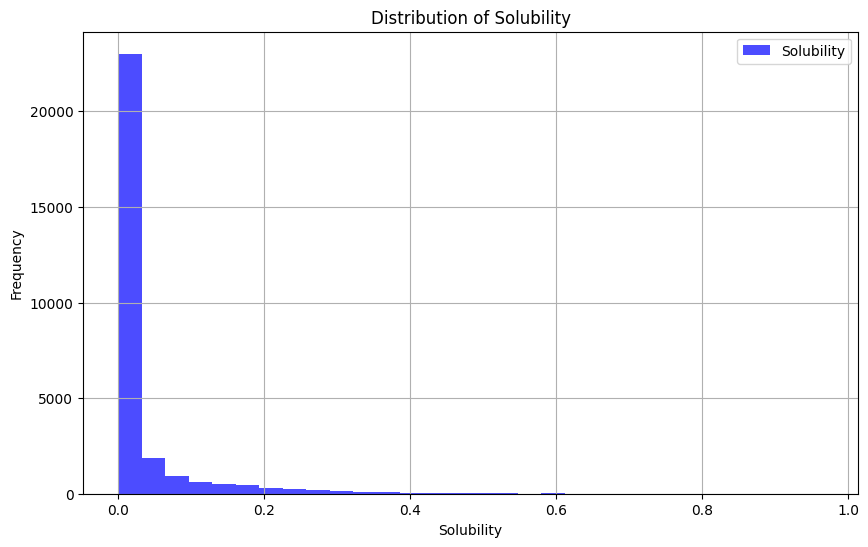

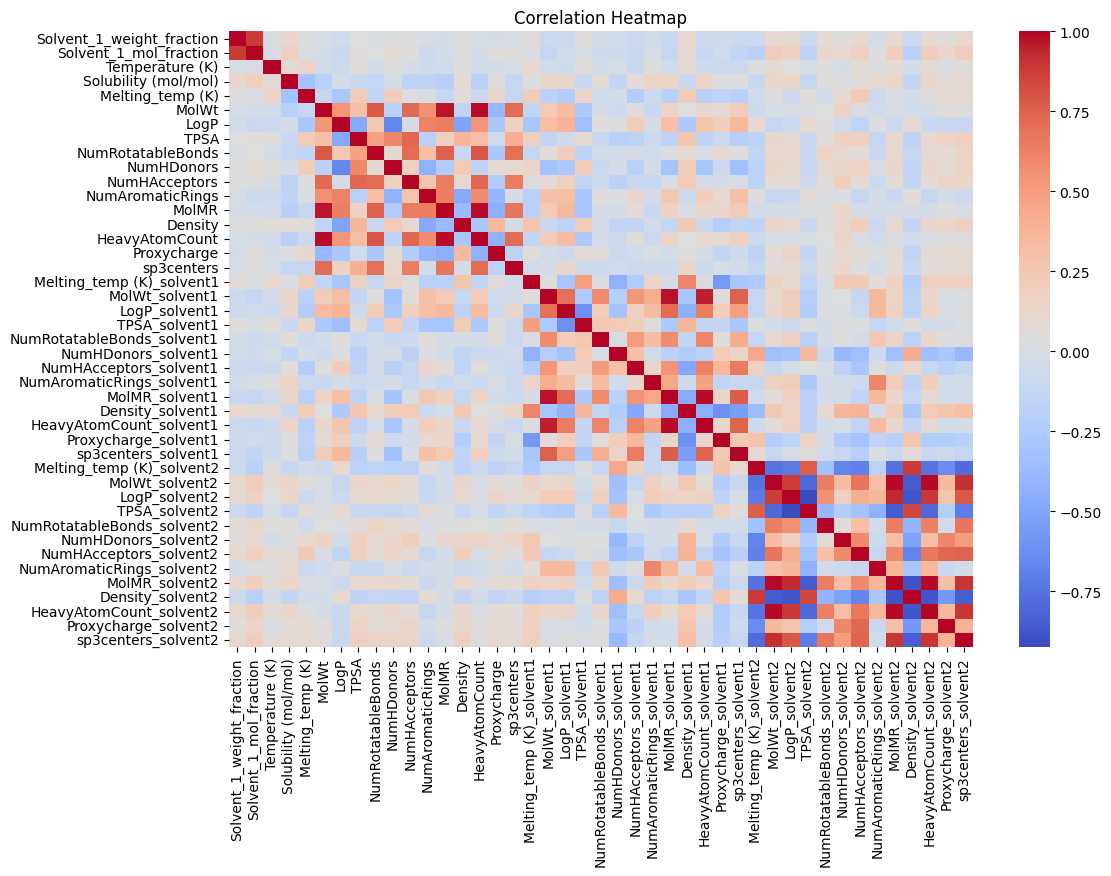

Dropped features due to high correlation: ['MolMR', 'HeavyAtomCount', 'MolMR_solvent1', 'HeavyAtomCount_solvent1', 'TPSA_solvent2', 'MolMR_solvent2', 'HeavyAtomCount_solvent2', 'sp3centers_solvent2']
Reduced dataset shape: (28703, 35)


In [7]:
# Load Merged Dataset
data = pd.read_csv('merged_solubility_value.csv')

# Step 1: EDA
# Visualize distributions
plt.figure(figsize=(10, 6))
data['Solubility (mol/mol)'].hist(bins=30, alpha=0.7, color='blue', label='Solubility')
plt.xlabel('Solubility')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility')
plt.legend()
plt.show()

# Correlation heatmap
data_numeric = data.select_dtypes(include=[float, int])
correlation_matrix = data_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()


def remove_highly_correlated_features(dataframe, threshold=0.9):
    """
    Removes highly correlated features from the dataframe based on a correlation threshold.

    Parameters:
        dataframe (pd.DataFrame): The input dataframe containing numeric features.
        threshold (float): The correlation threshold above which features are considered redundant.

    Returns:
        pd.DataFrame: A dataframe with highly correlated features removed.
    """
    # Calculate the correlation matrix
    corr_matrix = dataframe.corr().abs()

    # Mask the upper triangle of the correlation matrix
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    upper_triangle_matrix = corr_matrix.where(upper_triangle)

    # Identify columns to drop based on the threshold
    to_drop = [column for column in upper_triangle_matrix.columns if any(upper_triangle_matrix[column] > threshold)]

    # Drop the columns
    reduced_df = dataframe.drop(columns=to_drop)
    return reduced_df, to_drop

# Example usage
threshold = 0.9  # Define the correlation threshold
reduced_data, dropped_features = remove_highly_correlated_features(data_numeric, threshold)

reduced_data.to_csv('merged_solubility_reduced.csv', index=False)
print("Dropped features due to high correlation:", dropped_features)
print("Reduced dataset shape:", reduced_data.shape)






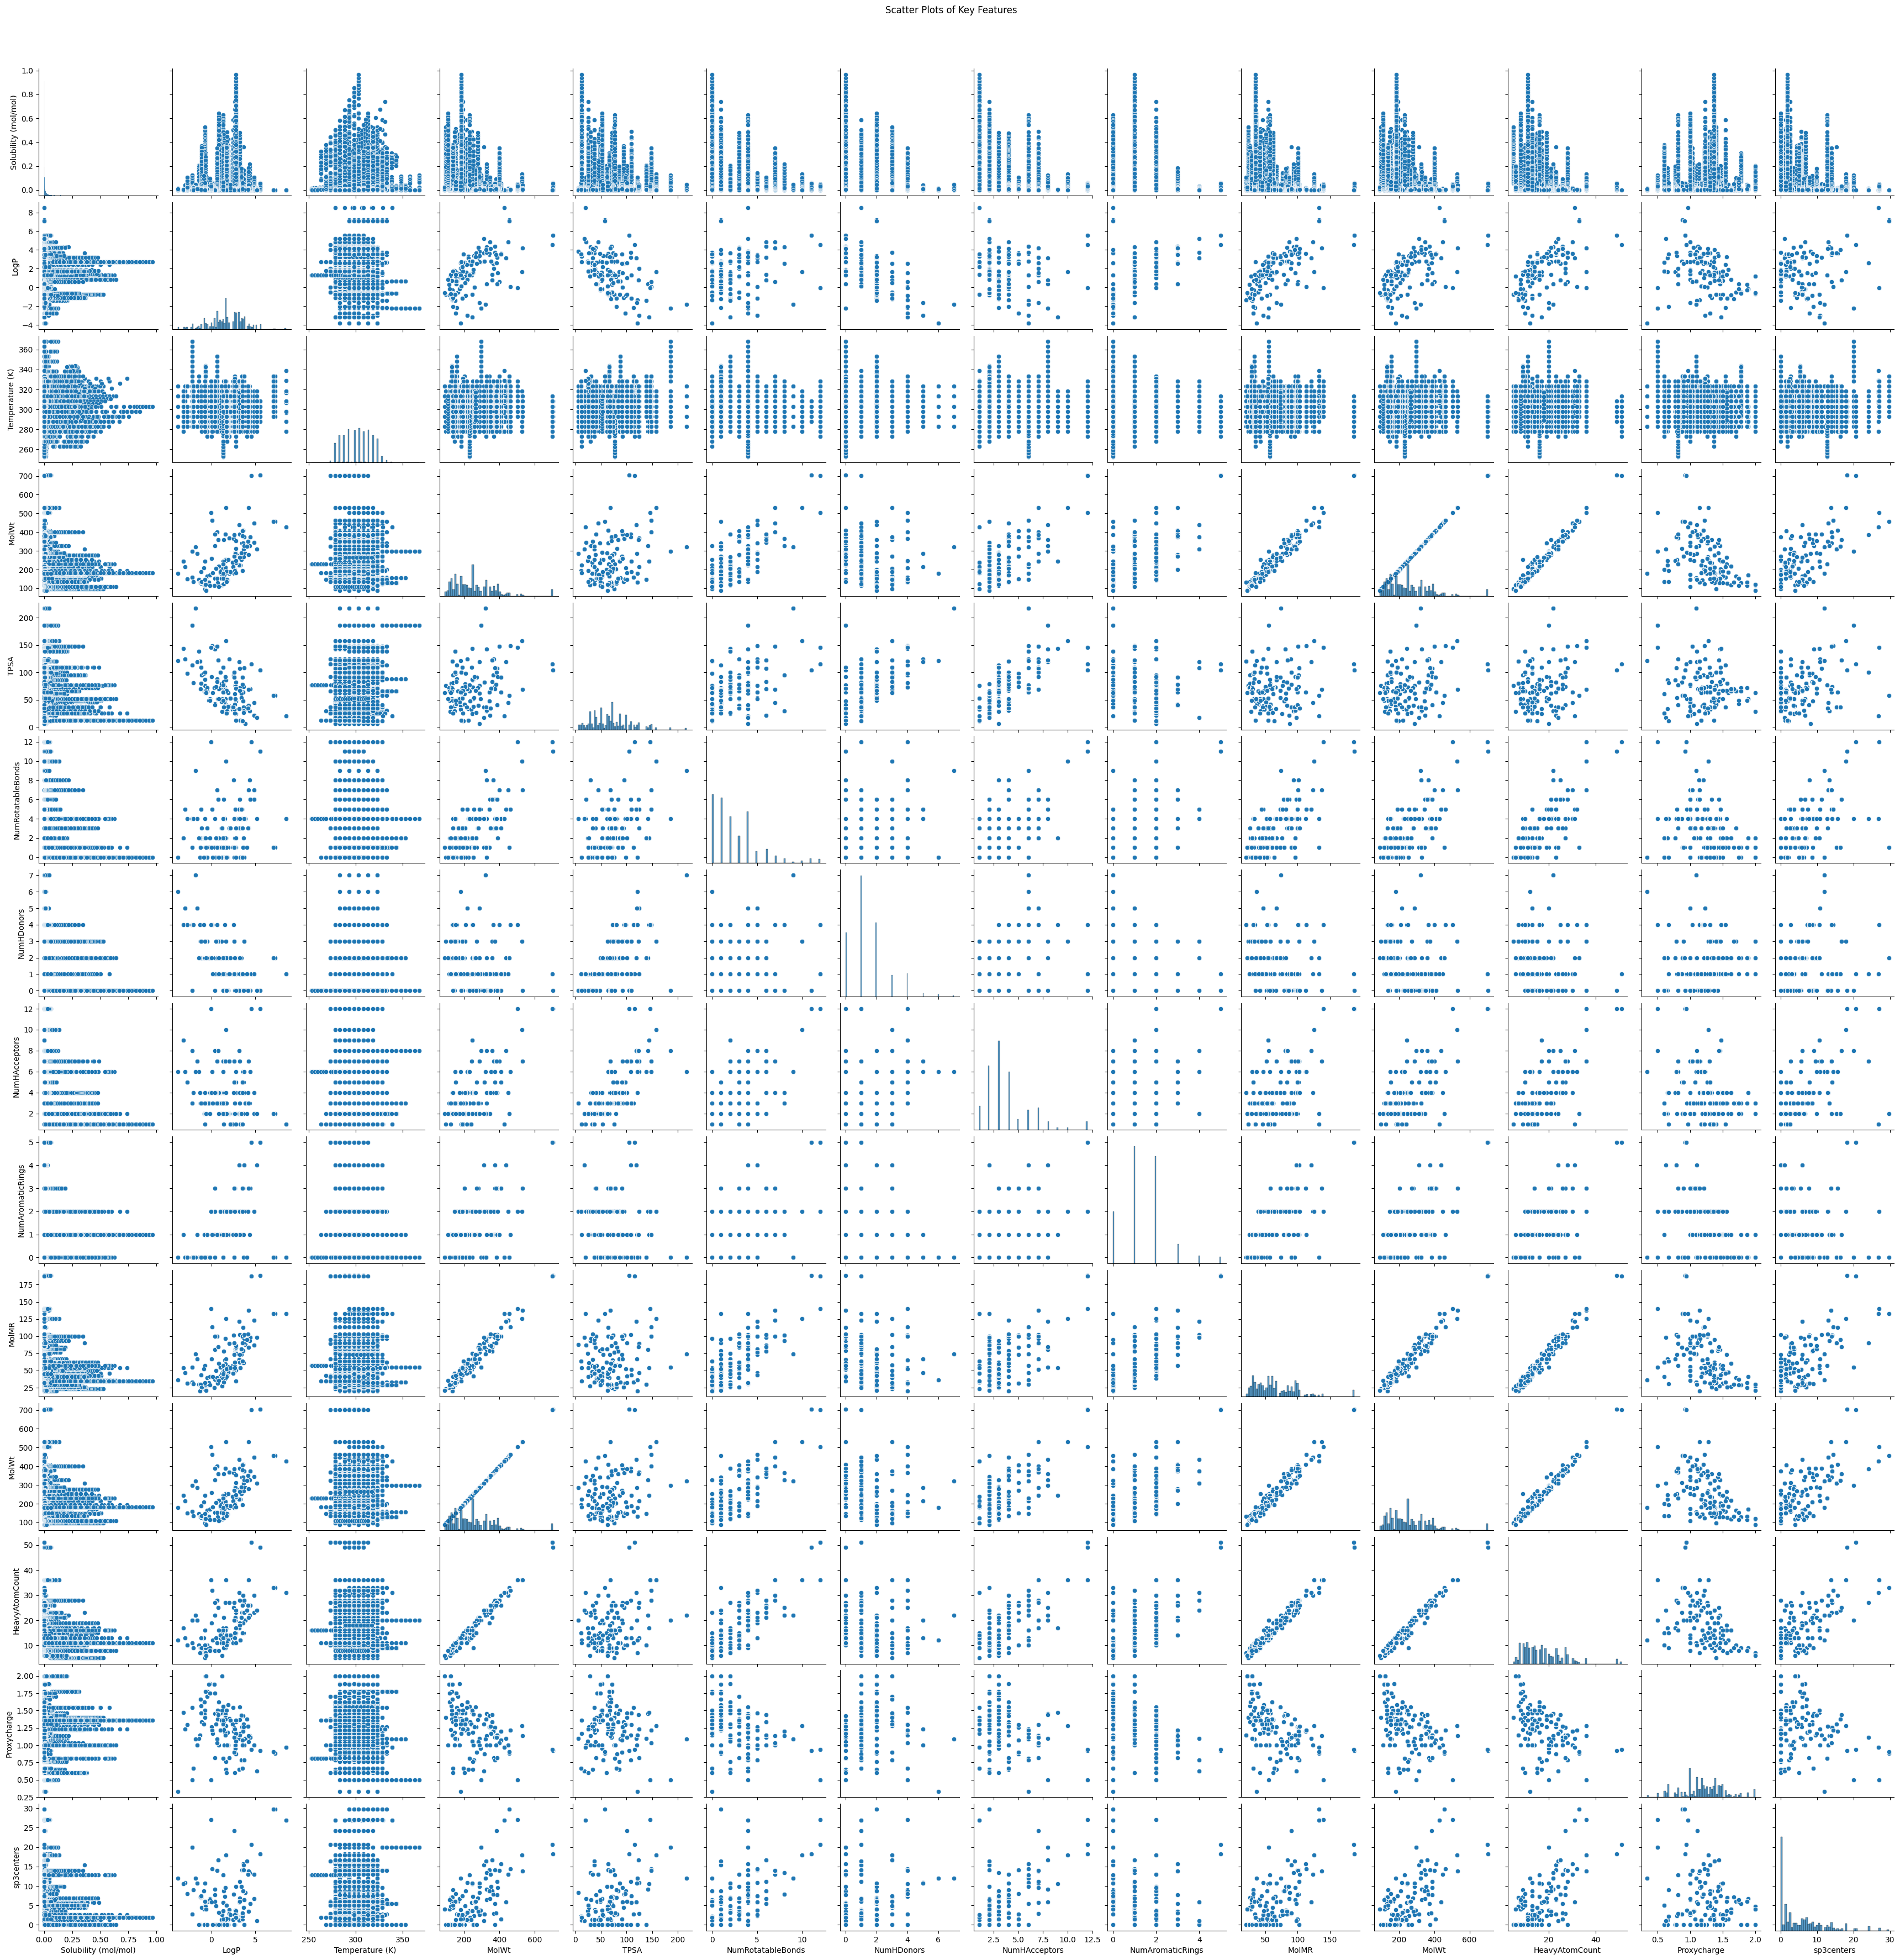

In [8]:
# Scatter plot of solubility vs key features
sns.pairplot(data, vars=['Solubility (mol/mol)', 'LogP', 'Temperature (K)', 'MolWt', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings', 'MolMR', 'MolWt', 'HeavyAtomCount', 'Proxycharge', 'sp3centers'])
plt.suptitle('Scatter Plots of Key Features', y=1.02)
plt.show()

# **Step 6: Train Model and Evaluate the result**

                      Model   CV RMSE  Test RMSE   Test R2
0         Linear Regression  0.069958   0.071535  0.115432
1          Ridge Regression  0.069958   0.071535  0.115431
2             Random Forest  0.037137   0.036471  0.770066
3         Gradient Boosting  0.042025   0.044763  0.653636
4       K-Nearest Neighbors  0.036568   0.036823  0.765609
5  Support Vector Regressor  0.062321   0.063511  0.302745


<ipython-input-15-dc13c79ed26f>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Test RMSE", data=results_df, palette="viridis")


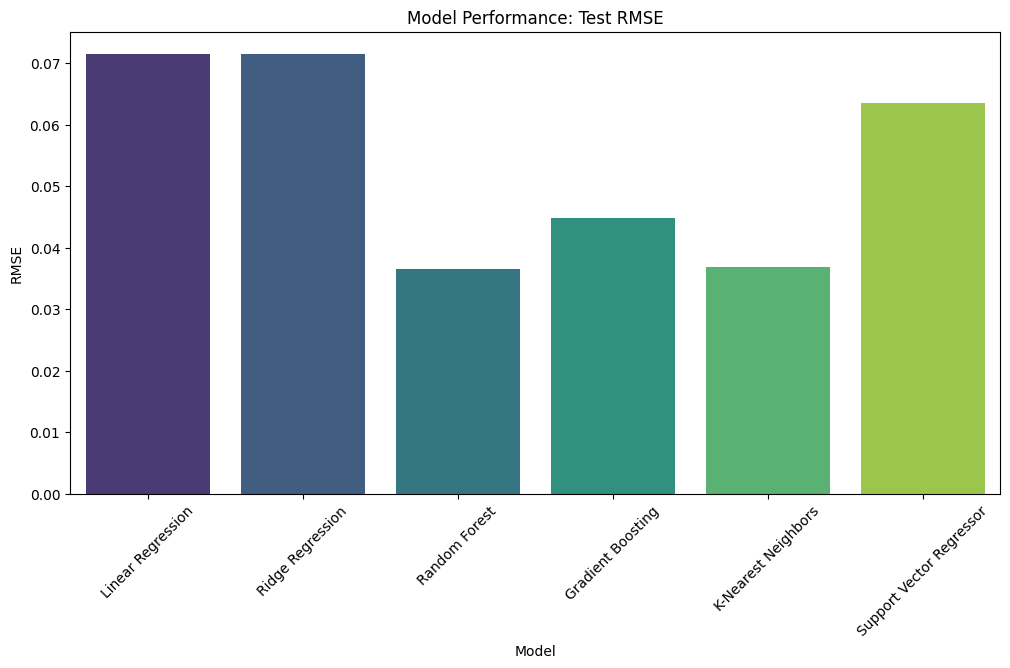

<ipython-input-15-dc13c79ed26f>:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Test R2", data=results_df, palette="viridis")


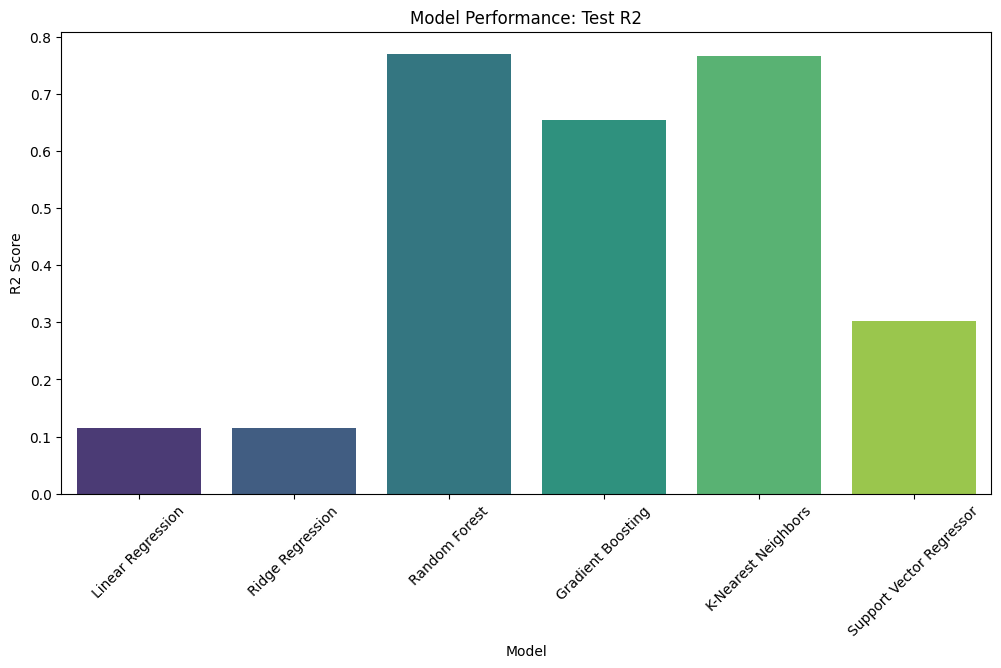

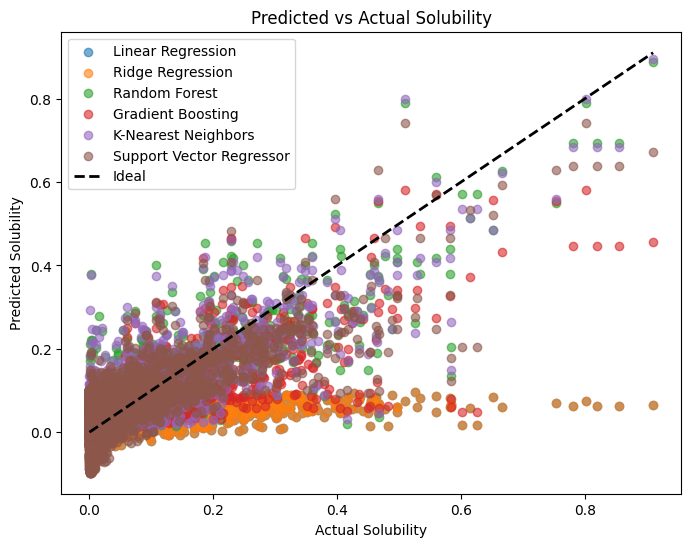

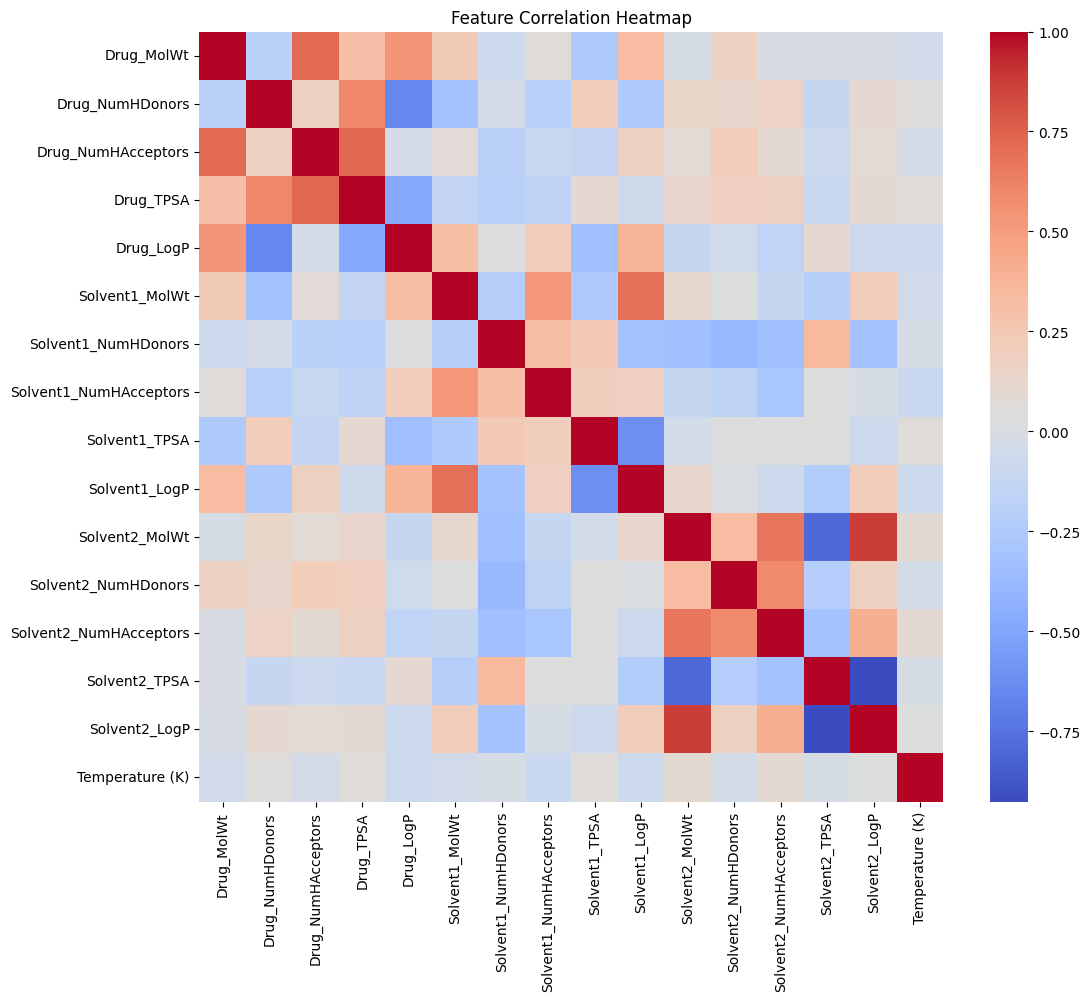

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv('merged_solubility_value.csv')

# Advanced Feature Engineering with RDKit
def compute_rdkit_descriptors(smiles):
    """Generate molecular descriptors for a SMILES string using RDKit."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            "MolWt": Descriptors.MolWt(mol),
            "NumHDonors": Descriptors.NumHDonors(mol),
            "NumHAcceptors": Descriptors.NumHAcceptors(mol),
            "TPSA": Descriptors.TPSA(mol),
            "LogP": Descriptors.MolLogP(mol),
        }
    else:
        return {
            "MolWt": np.nan,
            "NumHDonors": np.nan,
            "NumHAcceptors": np.nan,
            "TPSA": np.nan,
            "LogP": np.nan,
        }

# Apply RDKit descriptors for drugs and solvents
for col, prefix in zip(['SMILES', 'SMILES_solvent1', 'SMILES_solvent2'], ['Drug', 'Solvent1', 'Solvent2']):
    desc_df = data[col].apply(compute_rdkit_descriptors).apply(pd.Series)
    desc_df.columns = [f"{prefix}_{desc}" for desc in desc_df.columns]
    data = pd.concat([data, desc_df], axis=1)

# Combine features for modeling
X = pd.concat([
    data.filter(regex='Drug_'),         # Drug descriptors
    data.filter(regex='Solvent1_'),    # Solvent1 descriptors
    data.filter(regex='Solvent2_'),    # Solvent2 descriptors
    data[['Temperature (K)']]          # Temperature
], axis=1)

y = data['Solubility (mol/mol)']

# Handle missing values
X.fillna(X.mean(), inplace=True)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Support Vector Regressor": SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# Train and evaluate models
results = []
for name, model in models.items():
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores).mean()

    # Train the model
    model.fit(X_train, y_train)

    # Test predictions
    y_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    # Store results
    results.append({
        "Model": name,
        "CV RMSE": cv_rmse,
        "Test RMSE": test_rmse,
        "Test R2": test_r2
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print results
print(results_df)

# Visualization: Model Performance Comparison
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Test RMSE", data=results_df, palette="viridis")
plt.title("Model Performance: Test RMSE")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Test R2", data=results_df, palette="viridis")
plt.title("Model Performance: Test R2")
plt.ylabel("R2 Score")
plt.xticks(rotation=45)
plt.show()

# Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.6, label=name)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal')
plt.xlabel("Actual Solubility")
plt.ylabel("Predicted Solubility")
plt.title("Predicted vs Actual Solubility")
plt.legend()
plt.show()

# Pairwise Feature Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


# **Step 7: Apply Feature Engineering & Apply PCA & Visualization of Dataset**

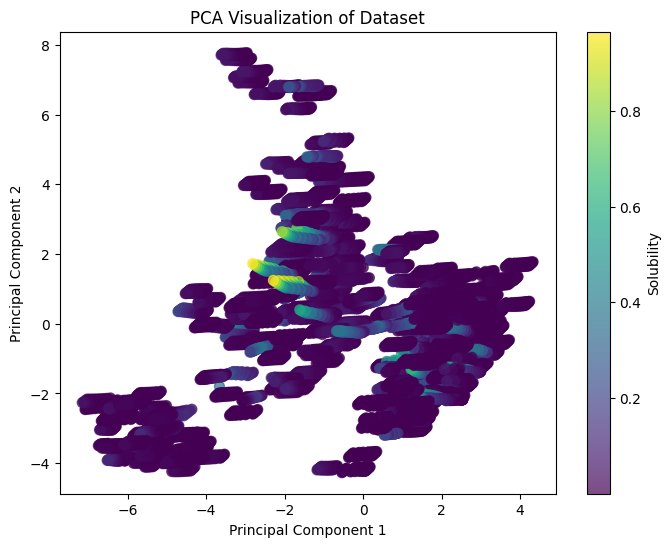

In [9]:
#PCA for visualization
features = [col for col in reduced_data.columns if col not in ['Solvent_1', 'Solvent_2', 'Solvent', 'solubility', 'Drug', 'SMILES', 'Solvent_solvent1', 'SMILES_solvent1', 'Solvent_solvent2', 'SMILES_solvent2']]
X = reduced_data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['Solubility (mol/mol)'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Solubility')
plt.title('PCA Visualization of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# **Step 8: Apply Feature Engineering to Retrain Final Model Training by Evaluation, and Visualization**

<ipython-input-13-60437212832c>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Test RMSE", data=results_df, palette="viridis")


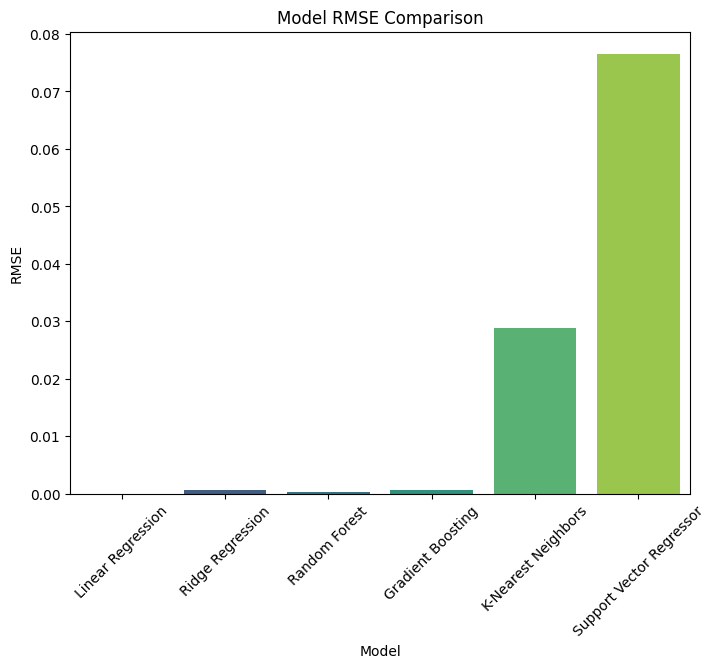

<ipython-input-13-60437212832c>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Test R2", data=results_df, palette="viridis")


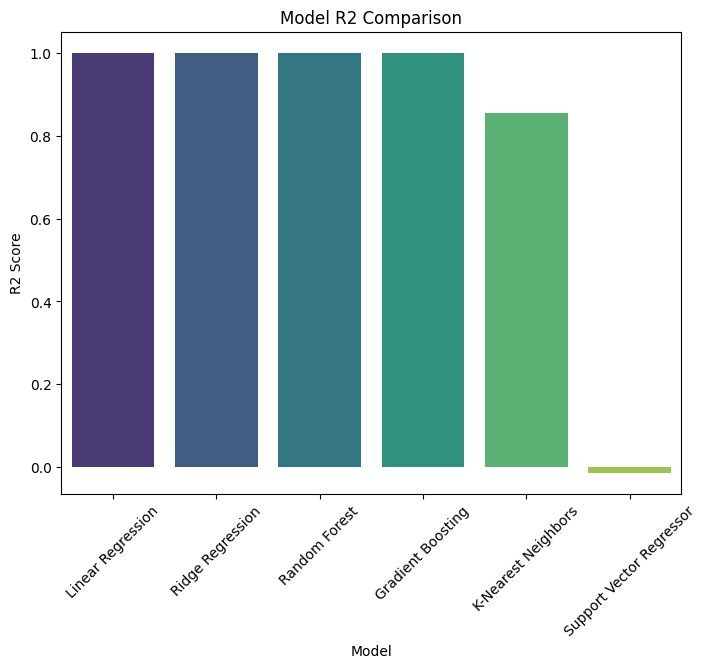

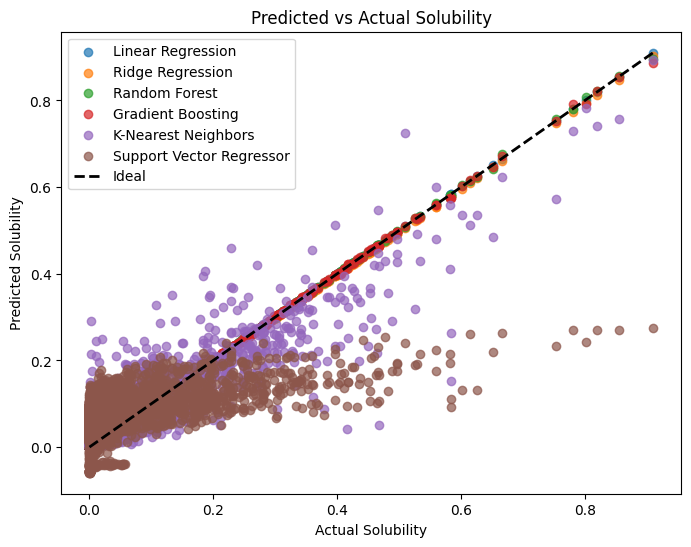

Model Performance Metrics:
                      Model       CV RMSE     Test RMSE   Test R2
0         Linear Regression  1.888673e-14  1.230395e-14  1.000000
1          Ridge Regression  8.617176e-04  7.065336e-04  0.999914
2             Random Forest  4.250965e-04  3.426180e-04  0.999980
3         Gradient Boosting  7.033142e-04  7.261203e-04  0.999909
4       K-Nearest Neighbors  2.942228e-02  2.892440e-02  0.855381
5  Support Vector Regressor  7.542447e-02  7.656697e-02 -0.013395


In [13]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare Dataset
X = data[features]
y = data['Solubility (mol/mol)']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=100),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Support Vector Regressor": SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# Step 2: Train and Evaluate Models
results = []
for name, model in models.items():
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores).mean()

    # Train the model
    model.fit(X_train, y_train)

    # Test predictions
    y_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)

    # Store results
    results.append({
        "Model": name,
        "CV RMSE": cv_rmse,
        "Test RMSE": test_rmse,
        "Test R2": test_r2
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Step 3: Plot Metrics
# Bar Plot for RMSE
plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="Test RMSE", data=results_df, palette="viridis")
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()

# Bar Plot for R2
plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y="Test R2", data=results_df, palette="viridis")
plt.title("Model R2 Comparison")
plt.ylabel("R2 Score")
plt.xticks(rotation=45)
plt.show()

# Step 4: Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred, alpha=0.7, label=name)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal')
plt.xlabel("Actual Solubility")
plt.ylabel("Predicted Solubility")
plt.legend()
plt.title("Predicted vs Actual Solubility")
plt.show()

# Step 5: Print Results
print("Model Performance Metrics:")
print(results_df)
